In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from scipy.constants import c as speed_of_light
from tqdm import tqdm
from numba import njit, jit, prange
from numba.typed import List
import time
from scipy.stats import mode
from numba.typed import List

In [2]:
@njit
def calc_flux(wl, flux, wlrange):
    """
    Calculates the flux of a flux density in Jy over a range of wavelengths in microns
    """
    mask = (wl >= wlrange[0]) & (wl <= wlrange[1])
    return total_flux(wl[mask], flux[mask])


@njit
def total_flux(wl, flux_nu):
    """
    Calculate the total flux over the wavelengths and returns the flux in erg cm^-2 s^-1
    """
    if wl.size == 0:
        return 0
    flux_lambda = (speed_of_light * 100 / (wl * 1e-4) ** 2) * flux_nu * 1e-23
    tot_flux = np.trapezoid(flux_lambda, (wl * 1e-4))
    return tot_flux


def compress_to_numpy(model_names, species, df):
    dim1 = len(model_names)
    dim2 = len(species)

    arr = []

    for i, model_name in enumerate(model_names):
        row = []
        for j, species_name in enumerate(species):
            wavelength = df.loc[df['Model Name'] == model_name, f'FLiTs {species_name} Wavelength'].values[0]
            flux = df.loc[df['Model Name'] == model_name, f'FLiTs {species_name} Flux'].values[0]
            row.append((wavelength, flux))
        arr.append(row)

    numba_list = List()
    for row in arr:
        numba_row = List()
        for item in row:
            numba_row.append(item)
        numba_list.append(numba_row)

    return numba_list


@njit(parallel=True)
def spectral_window(min_wl, max_wl, window_size, arr, min_flux):
    windows_array = np.arange(min_wl, max_wl, window_size)
    num_models = len(arr)
    num_windows = len(windows_array)

    dom = np.full((num_models, num_windows), -1, dtype=np.int32)

    # Parallelize the outer loop using prange
    for i in prange(num_models):
        for index_window in range(num_windows):
            window_start = windows_array[index_window]
            window_end = window_start + window_size

            max_flux = total_flux(np.linspace(window_start, window_end, 2), min_flux)
            dominant_specie_index = -1

            for j in range(len(arr[i])):
                wavelength, flux = arr[i][j]

                flux_value = calc_flux(wavelength, flux, [window_start, window_end])
                if flux_value > max_flux:
                    max_flux = flux_value
                    dominant_specie_index = j

            dom[i, index_window] = dominant_specie_index

    return windows_array, dom

In [3]:
# Open the data 
with open('FLiTsData1000_N.pkl', 'rb') as f:
    df = pickle.load(f)
# df.head()

In [15]:
color = {'atomic': 'tomato', 'C2H2': 'yellow', 'CH4': 'mediumorchid', 'CO': 'red', 'CO2': 'limegreen', 'H2O': 'dodgerblue',
          'HCN': 'orange', 'NH3': 'cyan', 'NO': 'gold', 'OH': 'magenta'}

In [5]:
df['CO Value'] = pd.to_numeric(df['CO Value'], errors="coerce")
model_names = np.array(df.loc[df['CO Value']>1, 'Model Name'].values)
print(model_names)
species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'O2', 'OH']
min_wl = 4.9
max_wl = 28.1
window_size = .001

arr = compress_to_numpy(model_names, species, df)
windows, dominant = spectral_window(min_wl, max_wl, window_size, arr, 1e-5)

['C_0.0_O_-0.5_CO_1.445' 'C_0.25_O_-0.5_CO_2.570'
 'C_0.25_O_-0.25_CO_1.445' 'C_0.5_O_-0.5_CO_4.57' 'C_0.5_O_-0.25_CO_2.570'
 'C_0.5_O_0.0_CO_1.445']


C:\Users\Niels de Klerk\AppData\Local\Temp\ipykernel_3316\1880555984.py:63: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  for j in range(len(arr[i])):


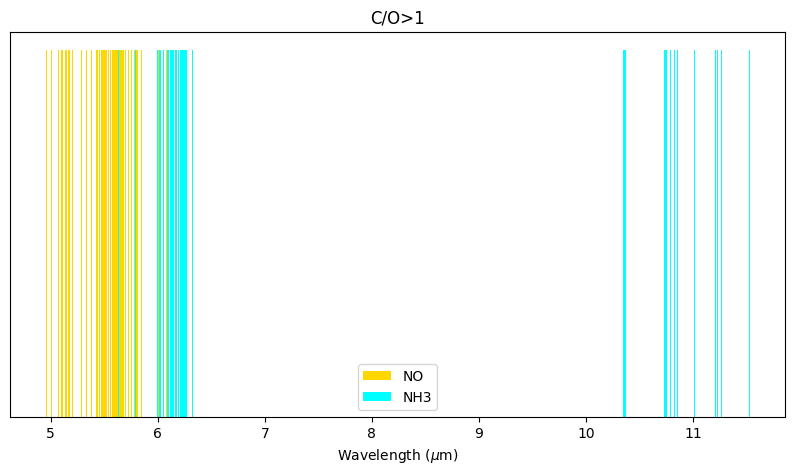

In [6]:
majority_values = mode(dominant, axis=0).mode
colors = plt.colormaps["tab10"].colors[:len(np.unique(majority_values))]
name_colors = dict(zip(np.unique(majority_values), colors))
new_species = species + ['Different']

plt.figure(figsize=(10, 5))
for i in range(len(windows)):
    if new_species[majority_values[i]] in ['NO', 'NH3']:
        plt.bar(windows[i], 1, width=window_size, color=color[new_species[majority_values[i]]], label=new_species[majority_values[i]])

handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys())
plt.xlabel(r'Wavelength ($\mu$m)')
plt.yticks([])
plt.title('C/O>1')
# plt.xlim(4.9, 6.5)
plt.savefig('Figures/ClassificationCOgt0.pdf', bbox_inches='tight', dpi=600)
plt.show()

In [7]:
df['CO Value'] = pd.to_numeric(df['CO Value'], errors="coerce")
model_names = np.array(df.loc[df['CO Value']<1, 'Model Name'].values)
print(model_names)
species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'O2', 'OH']
min_wl = 4.9
max_wl = 28.1
window_size = .001

arr = compress_to_numpy(model_names, species, df)
new_windows, new_dominant = spectral_window(min_wl, max_wl, window_size, arr, 1e-5)

['C_-0.5_O_-0.5_CO_0.45' 'C_-0.5_O_-0.25_CO_0.2570'
 'C_-0.5_O_0.0_CO_0.145' 'C_-0.5_O_0.25_CO_0.0813' 'C_-0.5_O_0.5_CO_0.045'
 'C_-0.25_O_-0.5_CO_0.813' 'C_-0.25_O_-0.25_CO_0.45'
 'C_-0.25_O_0.0_CO_0.257' 'C_-0.25_O_0.25_CO_0.145'
 'C_-0.25_O_0.5_CO_0.0813' 'C_0.0_O_-0.25_CO_0.813' 'C_0.0_O_0.0_CO_0.45'
 'C_0.0_O_0.25_CO_0.257' 'C_0.0_O_0.5_CO_0.145' 'C_0.25_O_0.0_CO_0.813'
 'C_0.25_O_0.25_CO_0.45' 'C_0.25_O_0.5_CO_0.2570' 'C_0.5_O_0.25_CO_0.813'
 'C_0.5_O_0.5_CO_0.45']


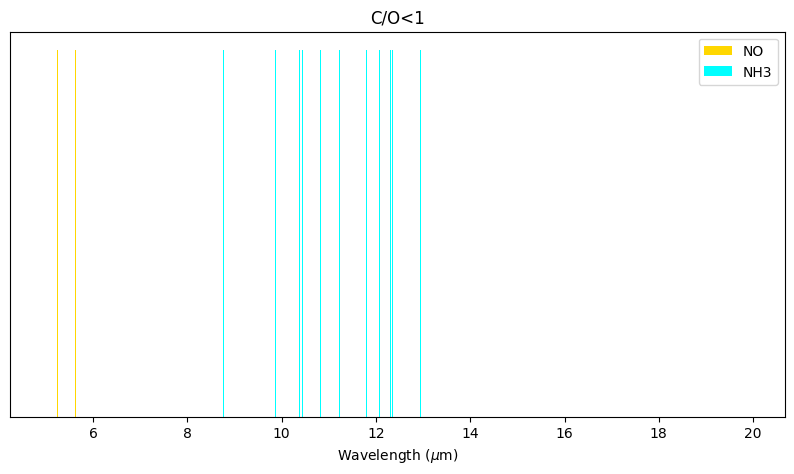

In [8]:
majority_values = mode(new_dominant, axis=0).mode
colors = plt.colormaps["tab10"].colors[:len(np.unique(majority_values))]
name_colors = dict(zip(np.unique(majority_values), colors))
new_species = species + ['Different']

plt.figure(figsize=(10, 5))
for i in range(len(new_windows)):
    if new_species[majority_values[i]] in ['NO', 'NH3']:
        # print(windows[i], new_species[majority_values[i]])
        plt.bar(windows[i], 1, width=window_size, color=color[new_species[majority_values[i]]], label=new_species[majority_values[i]])

handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys())
plt.xlabel(r'Wavelength ($\mu$m)')
plt.yticks([])
plt.title('C/O<1')
# plt.xlim(18, 20.1)
plt.savefig('Figures/ClassificationCOst0.pdf', bbox_inches='tight', dpi=600)
plt.show()

In [20]:
plt.rcParams.update({'font.size': 14})

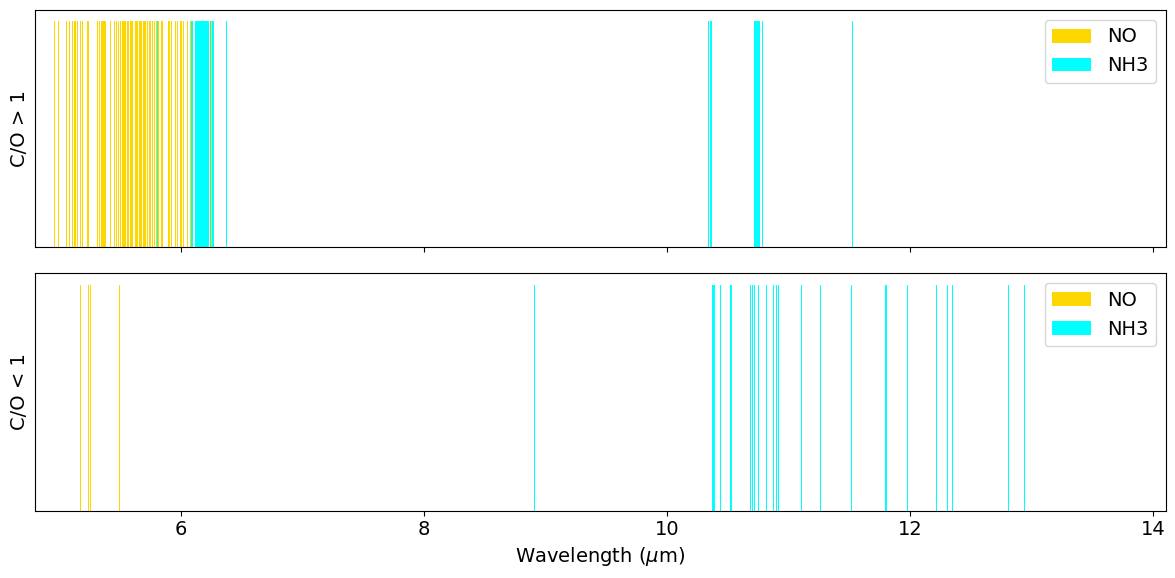

In [22]:
majority_values_1 = mode(dominant, axis=0).mode
majority_values_2 = mode(new_dominant, axis=0).mode

# colors = plt.colormaps["tab10"].colors
new_species = species + ['Different']

# Create color dictionary
unique_species = np.unique(np.concatenate([majority_values_1, majority_values_2]))
# name_colors = dict(zip(unique_species, colors[:len(unique_species)]))
# color = {new_species[i]: name_colors[i] for i in unique_species}

# Set up vertically stacked subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# --- Top plot: C/O > 1 ---
ax = axs[0]
for i in range(len(windows)):
    sp = new_species[majority_values_1[i]]
    if sp in ['NO', 'NH3']:
        ax.bar(windows[i], 1, width=window_size, color=color[sp], label=sp)

handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys())
ax.set_ylabel('C/O > 1')
ax.set_yticks([])
# ax.set_title('Dominant Molecules by Wavelength')

# --- Bottom plot: C/O < 1 ---
ax = axs[1]
for i in range(len(new_windows)):
    sp = new_species[majority_values_2[i]]
    if sp in ['NO', 'NH3']:
        ax.bar(windows[i], 1, width=window_size, color=color[sp], label=sp)

handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys())
ax.set_ylabel('C/O < 1')
ax.set_yticks([])
ax.set_xlabel(r'Wavelength ($\mu$m)')
ax.set_xlim(4.8, 14.1)
plt.tight_layout()
plt.savefig('Figures/ClassificationCO.pdf', bbox_inches='tight', dpi=600)
plt.show()